In [24]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch the historical market data
str = "AAPL"
data = yf.download(str, start='2010-01-01', end='2023-10-01')
data = data.copy()



[*********************100%%**********************]  1 of 1 completed


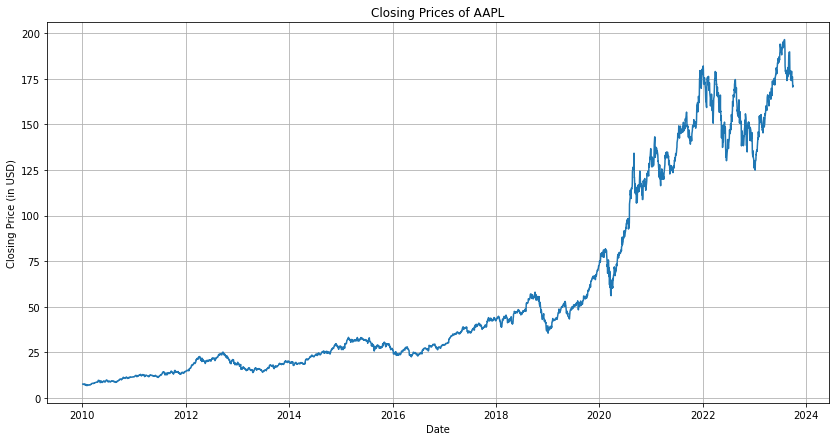

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(data["Close"])

plt.title('Closing Prices of AAPL')
plt.xlabel('Date')
plt.ylabel('Closing Price (in USD)')
plt.grid(True)
plt.show()

In [26]:
# Create a new column for 'Tomorrow' to be used as a learning model 
# Feature engineering
data['Tomorrow'] = data['Close'].shift(-1)
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)
data = data.dropna()

data

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487532,493729600,7.656429,1
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800,7.534643,0
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395378,552160000,7.520714,0
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200,7.570714,1
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425995,447610800,7.503929,0
...,...,...,...,...,...,...,...,...
2023-09-22,174.669998,177.080002,174.050003,174.789993,174.789993,56725400,176.080002,1
2023-09-25,174.199997,176.970001,174.149994,176.080002,176.080002,46172700,171.960007,0
2023-09-26,174.820007,175.199997,171.660004,171.960007,171.960007,64588900,170.429993,0


In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-500]
test = data.iloc[-500:]

predictors= ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [28]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])


In [29]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [30]:
precision_score(test["Target"], preds)


0.5925925925925926

In [31]:
combined = pd.concat([test["Target"], preds], axis = 1)

<AxesSubplot:xlabel='Date'>

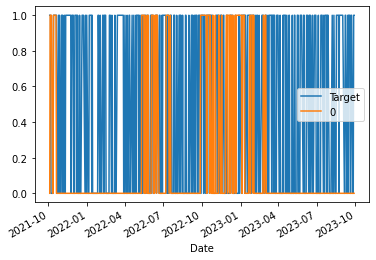

In [32]:
combined.plot()

In [33]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [34]:
def backtest(data, model, predictors, start = 500, step = 125):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [35]:
predictions = backtest(data, model, predictors)

In [36]:
predictions["Predictions"].value_counts()


Predictions
0    1906
1    1052
Name: count, dtype: int64

In [37]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5057034220532319

In [38]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data.loc[:, ratio_column] = data["Close"]/rolling_averages["Close"]
    #ratios between closes in the last x amount of time 
    trend_column = f"Trend_{horizon}"
    data.loc[:, trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]
      
    

In [39]:
data = data.dropna()

In [40]:
data

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,
2013-12-23,20.285713,20.382856,20.098572,20.360357,17.873268,501306400,20.273930,0,1.018827,2.0,1.029292,2.0,1.085065,33.0,1.209318,126.0,1.366124,528.0
2013-12-24,20.353214,20.424286,20.215357,20.273930,17.797396,167554800,20.139286,0,0.997873,1.0,1.020252,2.0,1.077352,33.0,1.203647,125.0,1.359175,527.0
2013-12-26,20.289286,20.339287,20.120714,20.139286,17.679201,204008000,20.003214,0,0.996668,0.0,1.008715,2.0,1.067633,32.0,1.195103,125.0,1.349008,527.0
2013-12-27,20.136429,20.157499,19.982143,20.003214,17.559752,225884400,19.804285,0,0.996610,0.0,0.996328,2.0,1.058064,31.0,1.186747,124.0,1.338774,527.0
2013-12-30,19.909286,20.003214,19.725714,19.804285,17.385122,253629600,20.036428,1,0.995003,0.0,0.984494,1.0,1.045202,31.0,1.174891,123.0,1.324376,526.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-22,174.669998,177.080002,174.050003,174.789993,174.789993,56725400,176.080002,1,1.002466,1.0,0.991716,3.0,0.946824,32.0,1.082131,132.0,1.312566,530.0
2023-09-25,174.199997,176.970001,174.149994,176.080002,176.080002,46172700,171.960007,0,1.003677,2.0,1.001183,3.0,0.954977,32.0,1.089434,132.0,1.321054,530.0
2023-09-26,174.820007,175.199997,171.660004,171.960007,171.960007,64588900,170.429993,0,0.988162,1.0,0.985727,2.0,0.934491,31.0,1.063412,131.0,1.289029,529.0


In [41]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] 
    #set a custom threshold, so it will only decide to trade when it is confident the stock will go up
    preds[preds>=.6] = 1
    preds[preds<.6]=0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [43]:
predictions = backtest(data, model, new_predictors)

In [44]:
predictions["Predictions"].value_counts()

Predictions
0.0    1679
1.0     279
Name: count, dtype: int64

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5376344086021505

In [46]:
data.to_csv(str+".csv")